# REDD Dataset Exploration

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from pathlib import Path
import matplotlib.pyplot as plt
import datetime
import math

%matplotlib inline
plt.rcParams['figure.figsize'] = (30.0, 20.0)

## Import dataset

In [2]:
DATASET = Path("Datasets/REDD/low_freq/")
TARGET_HOUSE = "house_5"

In [3]:
house_dir = DATASET / TARGET_HOUSE
labels_file = house_dir / "labels.dat"
channel_files = list(house_dir.glob('channel_*.dat'))

** Available Appliances **

In [4]:
labels = pd.read_table(labels_file, sep = ' ', header = None, index_col = 0)
labels

,1
0,
1,mains
2,mains
3,microwave
4,lighting
5,outlets_unknown
6,furance
7,outlets_unknown
8,washer_dryer
9,washer_dryer


In [5]:
channels = None
for __channel_file in channel_files:
    __channel_n = __channel_file.stem.split('_')[1]
    __channel = pd.read_table(__channel_file, sep = ' ', names = ['' + labels[1][int(__channel_n)] + '@' + __channel_n], index_col = 0, parse_dates=True, date_parser=lambda t: datetime.datetime.fromtimestamp(int(t)))
    if channels is None:
        channels = __channel
    else:
        channels = pd.concat([channels, __channel], axis=1, join='inner')
del(__channel, __channel_n, __channel_file)


## Compare appliances over full dataset
Add applicance type to be plotted in the `TARGET_CHANNEL_NAMES` list

In [6]:
TARGET_CHANNEL_NAMES = ['mains', 'lighting', 'washer_dryer', 'refrigerator']

In [7]:
selected_channels = labels[labels[1].isin(TARGET_CHANNEL_NAMES)]
target_channels = (selected_channels[1] + '@' + selected_channels.index.astype(str)).tolist()
target_channels


['mains@1',
 'mains@2',
 'lighting@4',
 'washer_dryer@8',
 'washer_dryer@9',
 'lighting@14',
 'lighting@17',
 'refrigerator@18',
 'lighting@19',
 'lighting@23']

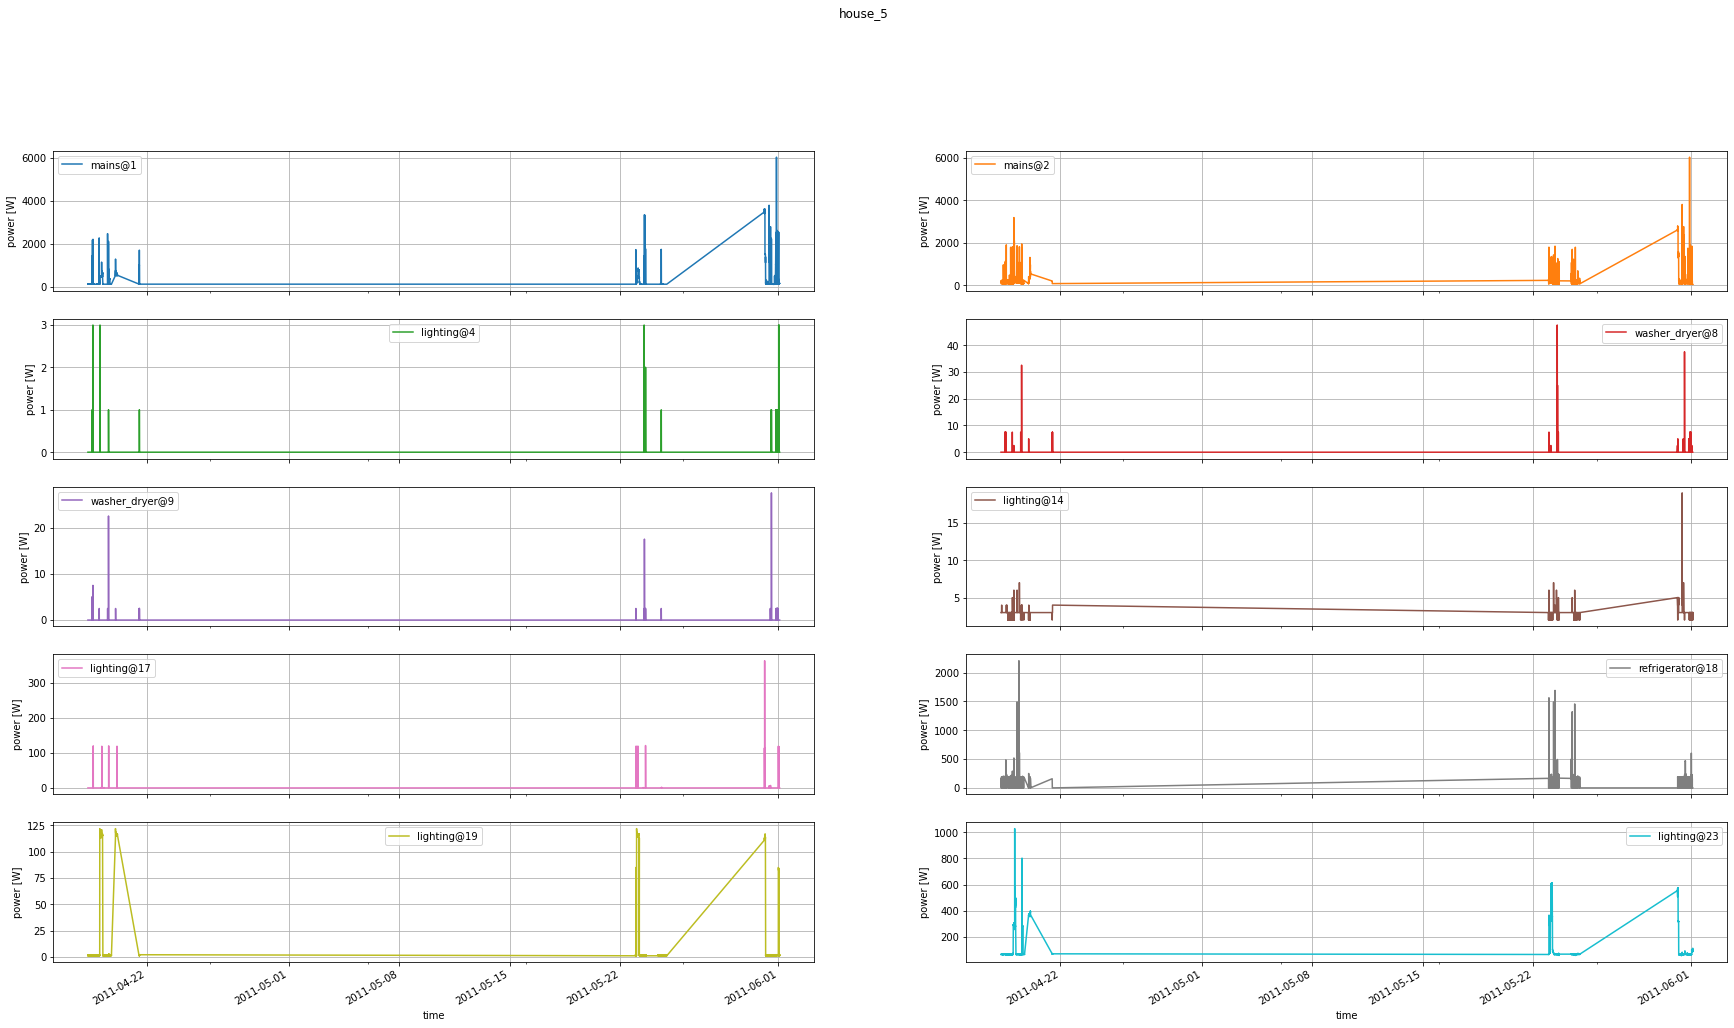

In [8]:
#%matplotlib widget
axes = channels.plot(y = target_channels, subplots = True, title = TARGET_HOUSE, xlabel = "time", ylabel = "power [W]", layout = (len(target_channels) // 2 + 1, 2), grid=True)


## Single appliance study

In [9]:
TARGET_CHANNEL_NAME = 'refrigerator@18' #refrigerator@18
channel = channels[TARGET_CHANNEL_NAME]

### Compare different timespans of same appliance
Set applicance identifier `<appliance_label@channel_number>` to be plotted in the `TARGET_CHANNEL_NAME` variable

Add the `(<begin_date>, <end_date>)` tuples delimiting the to-be-compared timespans in the `INTERVALS` list

In [10]:
INTERVALS = [
    ('2011-05-23 00:00:00', '2011-05-24 00:00:00'), 
    ('2011-05-24 00:00:00', '2011-05-25 00:00:00')
]

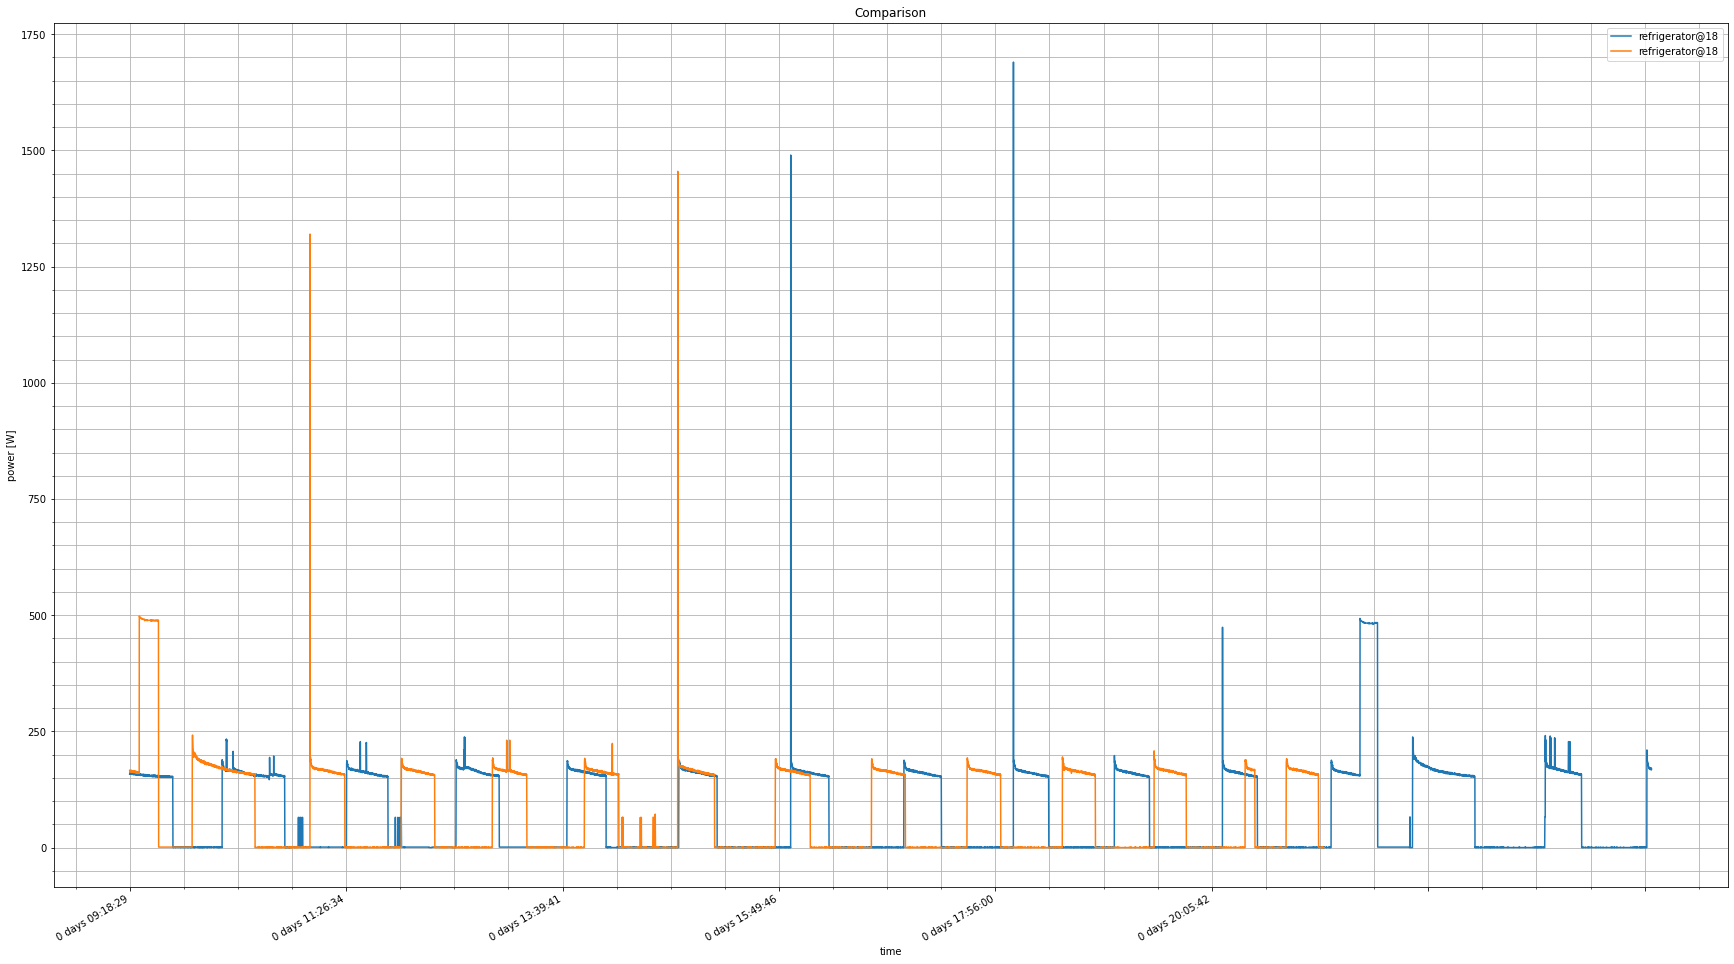

In [11]:
timeseries = [(datetime.datetime.strptime(b, '%Y-%m-%d %H:%M:%S'), channel.loc[b:e]) for (b,e) in INTERVALS]

fig = plt.figure()
fig.subplots_adjust(top=0.8)
axes = fig.add_subplot(1,1,1)
axes.set_title('Comparison')
axes.set_xlabel('time')
axes.set_ylabel('power [W]')

ax = None
for (b, ts) in timeseries:
    ts.index = ts.index - b
    if ax is None:
        ax = ts.plot(label = TARGET_CHANNEL_NAME)
    else:
        ts.plot(ax=ax, label = TARGET_CHANNEL_NAME)

axes.legend()
axes.minorticks_on()
axes.grid(which='both')
plt.show()

### Power Levels identification

In [12]:
from scipy import stats
KDE = sp.stats.gaussian_kde(channel)

In [13]:
from scipy.signal import argrelextrema
x = np.linspace(0, channel.max(), 2000)
y = KDE(x)
min_pos = argrelextrema(y, np.less_equal)
max_pos = argrelextrema(y, np.greater_equal)

original_bands = x[min_pos]


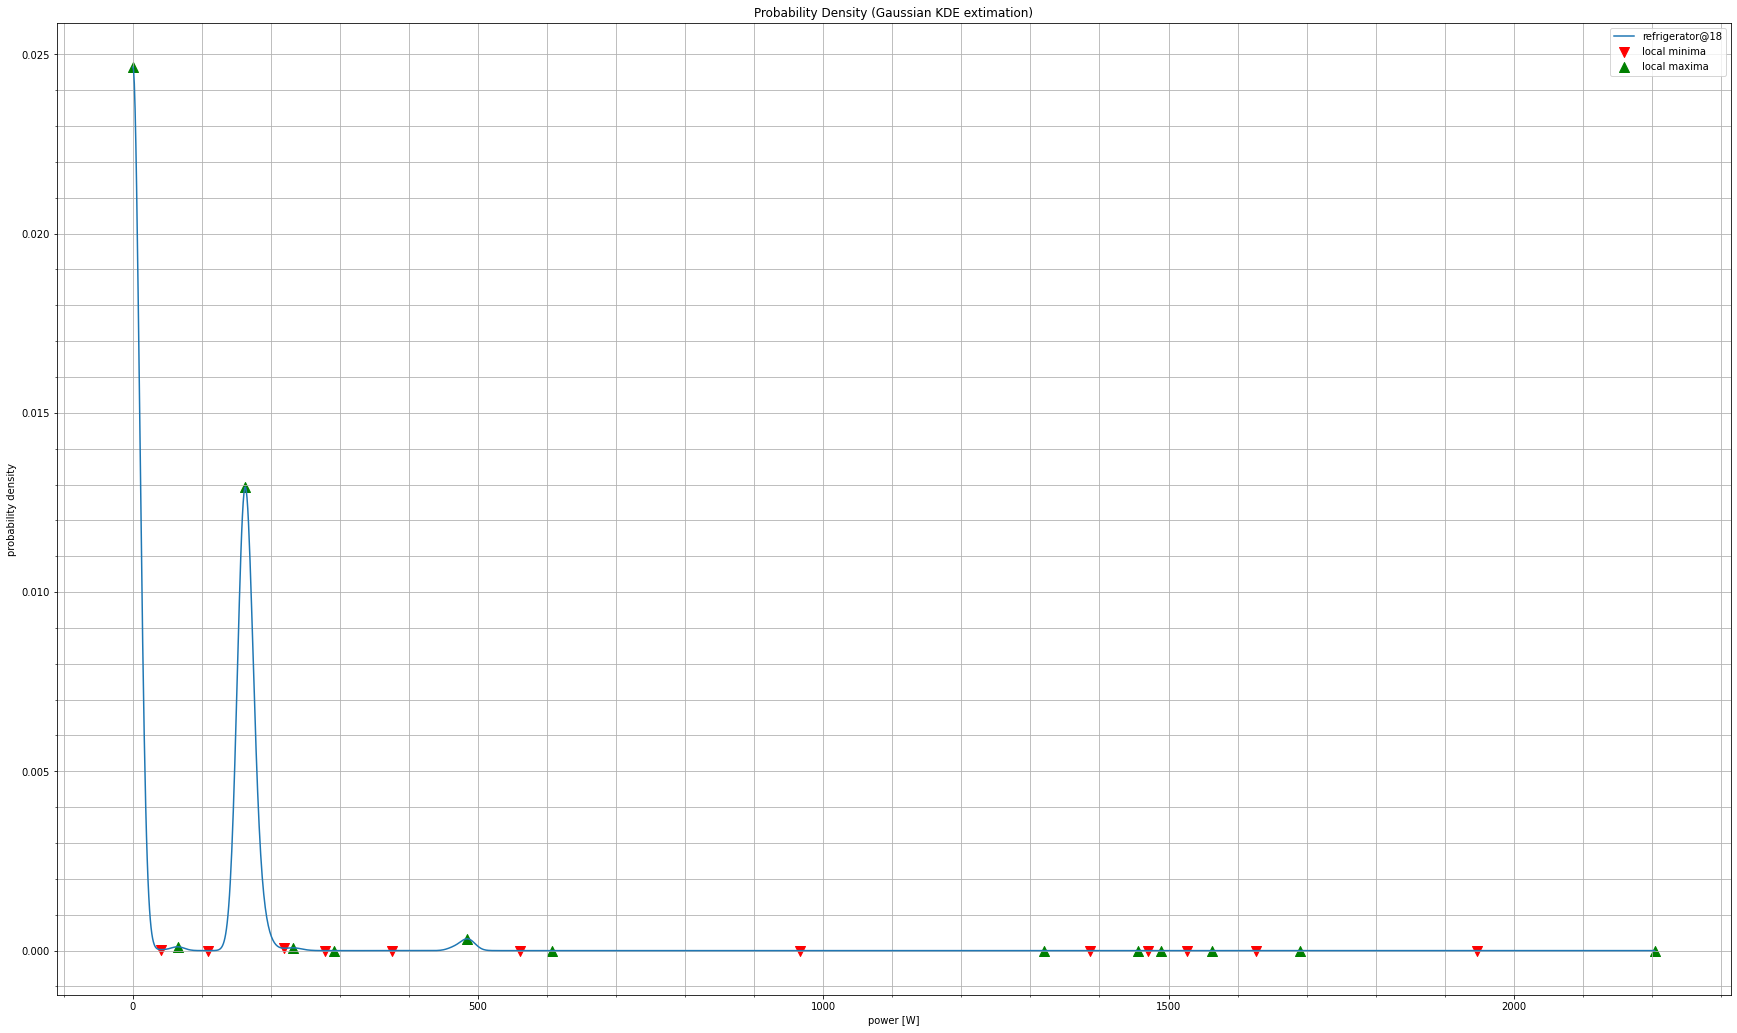

In [14]:
fig = plt.figure()
fig.subplots_adjust(top=0.8)
axes = fig.add_subplot(1,1,1)
axes.set_title('Probability Density (Gaussian KDE extimation)')
axes.set_xlabel('power [W]')
axes.set_ylabel('probability density')
axes.plot(x, y, label=TARGET_CHANNEL_NAME)
axes.scatter(x[min_pos], y[min_pos], s=100, marker='v', c='r', label='local minima')
axes.scatter(x[max_pos], y[max_pos], s=100, marker='^', c='g', label='local maxima')
axes.legend()
axes.minorticks_on()
axes.grid(which='both')
plt.show()


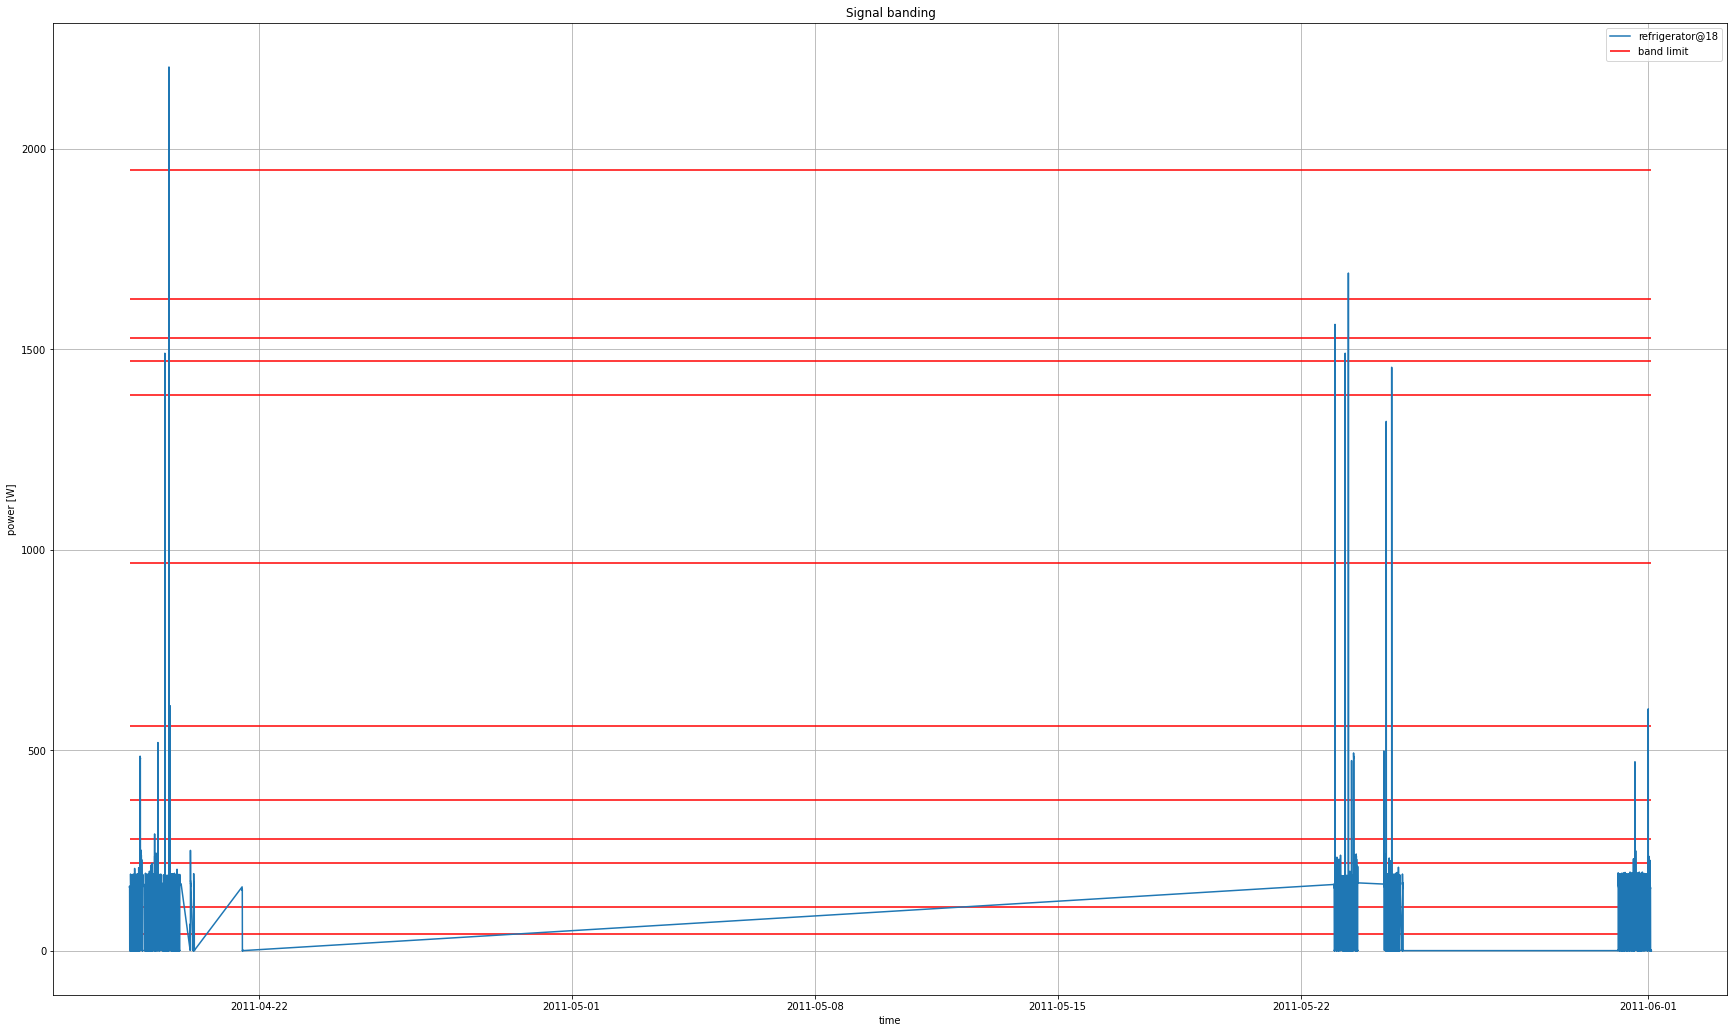

In [15]:
fig = plt.figure()
fig.subplots_adjust(top=0.8)
axes = fig.add_subplot(1,1,1)
axes.set_title('Signal banding')
axes.set_xlabel('time')
axes.set_ylabel('power [W]')
axes.plot(channel.index, channel, label=TARGET_CHANNEL_NAME)
axes.hlines(x[min_pos], channel.index.min(), channel.index.max(), colors='r', label='band limit')
axes.legend()
axes.grid(which='both')
plt.show()

In [16]:
bands = [channel.min()] + x[min_pos].tolist() + [channel.max()]

banded_channel = pd.DataFrame({'Power': channel})
banded_channel['Band'] = pd.cut(banded_channel['Power'], bins=x[min_pos], include_lowest=True)

band_stats = banded_channel.groupby('Band').describe()
band_stats

Power                                                 \
                        count         mean       std     min     25%     50%   
Band                                                                           
(40.793, 109.153]       238.0    61.609244  8.801290    41.0    65.0    65.0   
(109.153, 219.408]    29908.0   164.444430  8.030588   146.0   159.0   163.0   
(219.408, 278.945]      177.0   233.293785  7.239696   220.0   228.0   234.0   
(278.945, 374.867]        1.0   291.000000       NaN   291.0   291.0   291.0   
(374.867, 561.199]      806.0   481.512407  8.705776   462.0   479.0   483.0   
(561.199, 965.835]        2.0   607.000000  5.656854   603.0   605.0   607.0   
(965.835, 1387.01]        1.0  1320.000000       NaN  1320.0  1320.0  1320.0   
(1387.01, 1469.701]       1.0  1455.000000       NaN  1455.0  1455.0  1455.0   
(1469.701, 1527.034]      2.0  1490.000000  0.000000  1490.0  1490.0  1490.0   
(1527.034, 1626.263]      1.0  1562.000000       NaN  1562.0  1562.0  1562.0   
(1626.263, 1947.106]      1.0  1690.000000       NaN  1690.0  1690.0  1690.0   

                                      
                         75%     max  
Band                                  
(40.793, 109.153]       65.0    94.0  
(109.153, 219.408]     168.0   219.0  
(219.408, 278.945]     236.0   256.0  
(278.945, 374.867]     291.0   291.0  
(374.867, 561.199]     488.0   519.0  
(561.199, 965.835]     609.0   611.0  
(965.835, 1387.01]    1320.0  1320.0  
(1387.01, 1469.701]   1455.0  1455.0  
(1469.701, 1527.034]  1490.0  1490.0  
(1527.034, 1626.263]  1562.0  1562.0  
(1626.263, 1947.106]  1690.0  1690.0

In [17]:
#Aggregation algorythm
def aggregate_bands(dataset, column_label, initial_bands_delimiters, joining_threshold = 0.01, debug = False):
    __max_attempts = len(band_stats) ** 2
    def dprint(*args, **kargs):
        if debug:
            print(*args, **kargs)

    def __should_aggregate(sourceBand_idx, targetBand_idx, banding_stats):
        dprint("Trying to merge in ", sourceBand_idx)
        if banding_stats.loc[targetBand_idx, 'count'] * joining_threshold <= banding_stats.loc[sourceBand_idx, 'count']:
            return False
        else:
            std = banding_stats.loc[sourceBand_idx, 'std']
            if np.isnan(std):
                std = 1.0
            # TODO: refine with further threshold
            skewness = 3 * (banding_stats.loc[sourceBand_idx, 'mean'] - banding_stats.loc[sourceBand_idx, '50%']) / std
            dprint("Could aggregate. Checking Pearson's alternative coefficient of skewness...", skewness)
            if targetBand_idx.left == sourceBand_idx.right:
                return  skewness <= 0
            elif targetBand_idx.right == sourceBand_idx.left:
                return  skewness >= 0
            else:
                raise Exception('Trying to aggregate non continuous band')


    __bands = initial_bands_delimiters.copy()
    __available = np.full(len(__bands) - 1, True)

    for __attempt in range(__max_attempts, 0, -1):
        if __available.any() == False:
            dprint("No bands to examin. Finished!")
            break;

        __dataset = dataset.copy()

        __dataset['Band'] = pd.cut(__dataset[column_label], bins=__bands, include_lowest=True)
        __banding_stats = __dataset.groupby('Band').describe()
        __banding_stats.columns = __banding_stats.columns.map('{0[1]}'.format)
        
        dprint(__banding_stats)

        __biggest_band_idx = __banding_stats.loc[__available, 'count'].idxmax()
        __biggest_band_pos = __banding_stats.index.get_loc(__biggest_band_idx)

        dprint("Focusing on ", __biggest_band_idx)
        
        __neighboring_bands = []
        if __biggest_band_pos - 1  >= 0 and __banding_stats.loc[__banding_stats.index[__biggest_band_pos - 1], 'count'] < __banding_stats.loc[__biggest_band_idx, 'count']:
            __neighboring_bands.append(__banding_stats.index[__biggest_band_pos - 1])
        if __biggest_band_pos + 1 < len(__banding_stats.index) and __banding_stats.loc[__banding_stats.index[__biggest_band_pos + 1], 'count'] < __banding_stats.loc[__biggest_band_idx, 'count']:
            __neighboring_bands.append(__banding_stats.index[__biggest_band_pos + 1])

        __secundary_neighboring_band = None
        if len(__neighboring_bands) < 1:
            dprint("No smaller neighbouring bands... skipping.")
            __available[__biggest_band_pos] = False
            continue;
        elif len(__neighboring_bands) == 1:
            __target_neighboring_band = __neighboring_bands[0]
        elif len(__neighboring_bands) == 2:
            __target_neighboring_band, __secundary_neighboring_band = (__neighboring_bands[0], __neighboring_bands[1]) if __banding_stats.loc[__neighboring_bands[0], 'count'] > __banding_stats.loc[__neighboring_bands[1], 'count'] else (__neighboring_bands[1], __neighboring_bands[0])
        else:
            raise Exception('Too much neighboring bands!') 

        __to_be_merged = None

        if __should_aggregate(__target_neighboring_band, __biggest_band_idx, __banding_stats):
            __to_be_merged = __target_neighboring_band
        elif __secundary_neighboring_band != None and __should_aggregate(__secundary_neighboring_band, __biggest_band_idx, __banding_stats):
            __to_be_merged = __secundary_neighboring_band
        
        if __to_be_merged == None:
            __available[__biggest_band_pos] = False
            dprint(__biggest_band_idx, " could not be merged... skipping.")
        else:
            if __biggest_band_idx.left == __to_be_merged.right:
                dprint("Merging ", __to_be_merged, " and ", __biggest_band_idx)
                __bands = __bands[abs(__bands - __biggest_band_idx.left) > 0.01]
            elif __to_be_merged.left == __biggest_band_idx.right:
                dprint("Merging ", __biggest_band_idx, " and ", __to_be_merged)
                __bands = __bands[abs(__bands - __biggest_band_idx.right) > 0.01]
            else:
                raise Exception('Trying to aggregate non continuous band')
            __available = np.full(len(__bands) - 1, True)
    return __dataset
            

In [18]:
from tqdm.notebook import tnrange, tqdm

band_counts = []
INTERVALS = 250
for v in tnrange(INTERVALS, desc = 'threshold exploration'):
    i = v / INTERVALS 
    band_counts = band_counts + [(i, len(aggregate_bands(pd.DataFrame({'Power': channel}), 'Power', np.array(bands), joining_threshold=i)['Band'].unique()))]

band_counts

[(0.0, 13),
 (0.004, 9),
 (0.008, 8),
 (0.012, 8),
 (0.016, 8),
 (0.02, 8),
 (0.024, 8),
 (0.028, 8),
 (0.032, 8),
 (0.036, 8),
 (0.04, 8),
 (0.044, 8),
 (0.048, 8),
 (0.052, 8),
 (0.056, 8),
 (0.06, 8),
 (0.064, 8),
 (0.068, 8),
 (0.072, 8),
 (0.076, 8),
 (0.08, 8),
 (0.084, 8),
 (0.088, 8),
 (0.092, 8),
 (0.096, 8),
 (0.1, 8),
 (0.104, 8),
 (0.108, 8),
 (0.112, 8),
 (0.116, 8),
 (0.12, 8),
 (0.124, 8),
 (0.128, 8),
 (0.132, 8),
 (0.136, 8),
 (0.14, 8),
 (0.144, 8),
 (0.148, 8),
 (0.152, 8),
 (0.156, 8),
 (0.16, 8),
 (0.164, 8),
 (0.168, 8),
 (0.172, 8),
 (0.176, 8),
 (0.18, 8),
 (0.184, 8),
 (0.188, 8),
 (0.192, 8),
 (0.196, 8),
 (0.2, 8),
 (0.204, 8),
 (0.208, 8),
 (0.212, 8),
 (0.216, 8),
 (0.22, 7),
 (0.224, 7),
 (0.228, 7),
 (0.232, 7),
 (0.236, 7),
 (0.24, 7),
 (0.244, 7),
 (0.248, 7),
 (0.252, 7),
 (0.256, 7),
 (0.26, 7),
 (0.264, 7),
 (0.268, 7),
 (0.272, 7),
 (0.276, 7),
 (0.28, 7),
 (0.284, 7),
 (0.288, 7),
 (0.292, 7),
 (0.296, 7),
 (0.3, 7),
 (0.304, 7),
 (0.308, 7),
 (0.3

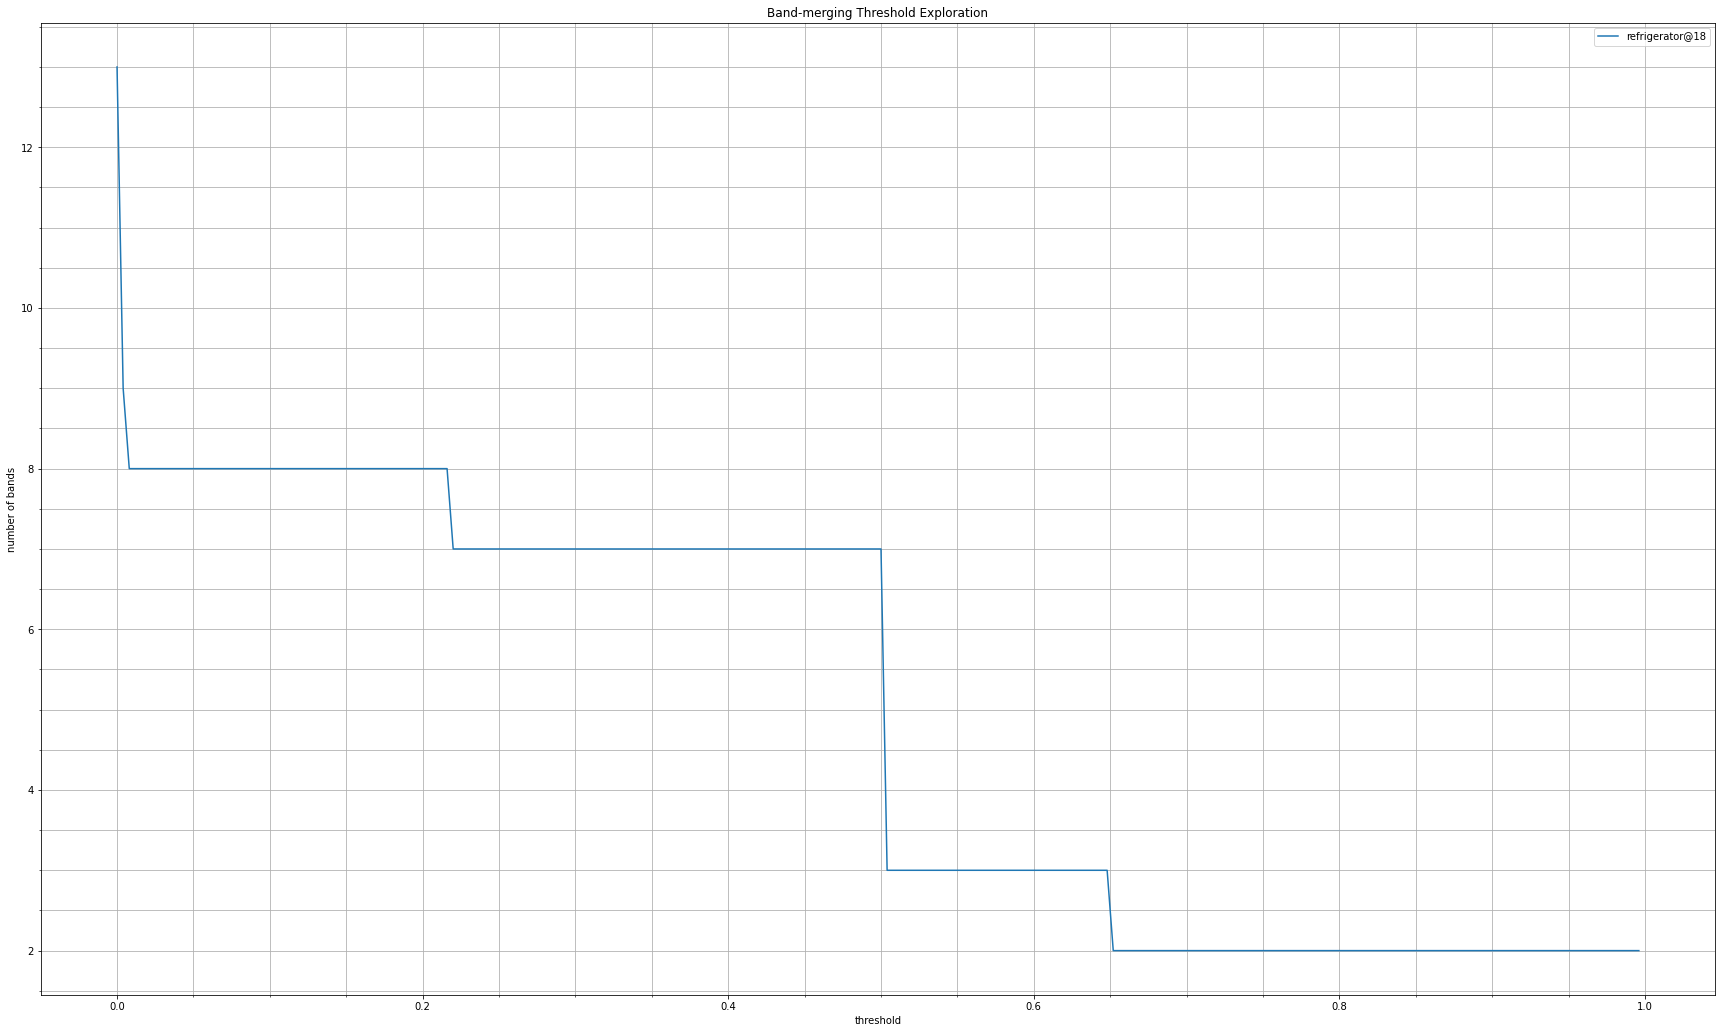

In [19]:
x, y = zip(*band_counts)

fig = plt.figure()
fig.subplots_adjust(top=0.8)
axes = fig.add_subplot(1,1,1)
axes.set_title('Band-merging Threshold Exploration')
axes.set_xlabel('threshold')
axes.set_ylabel('number of bands')
axes.plot(x, y, label=TARGET_CHANNEL_NAME)
axes.legend()
axes.minorticks_on()
axes.grid(which='both')
plt.show()



0.008

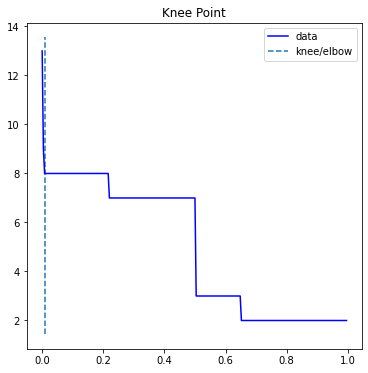

In [20]:
from kneed import KneeLocator

kneedle = KneeLocator(x, y, curve="convex", direction="decreasing")

kneedle.plot_knee()

optimal_threshold = kneedle.knee
optimal_threshold



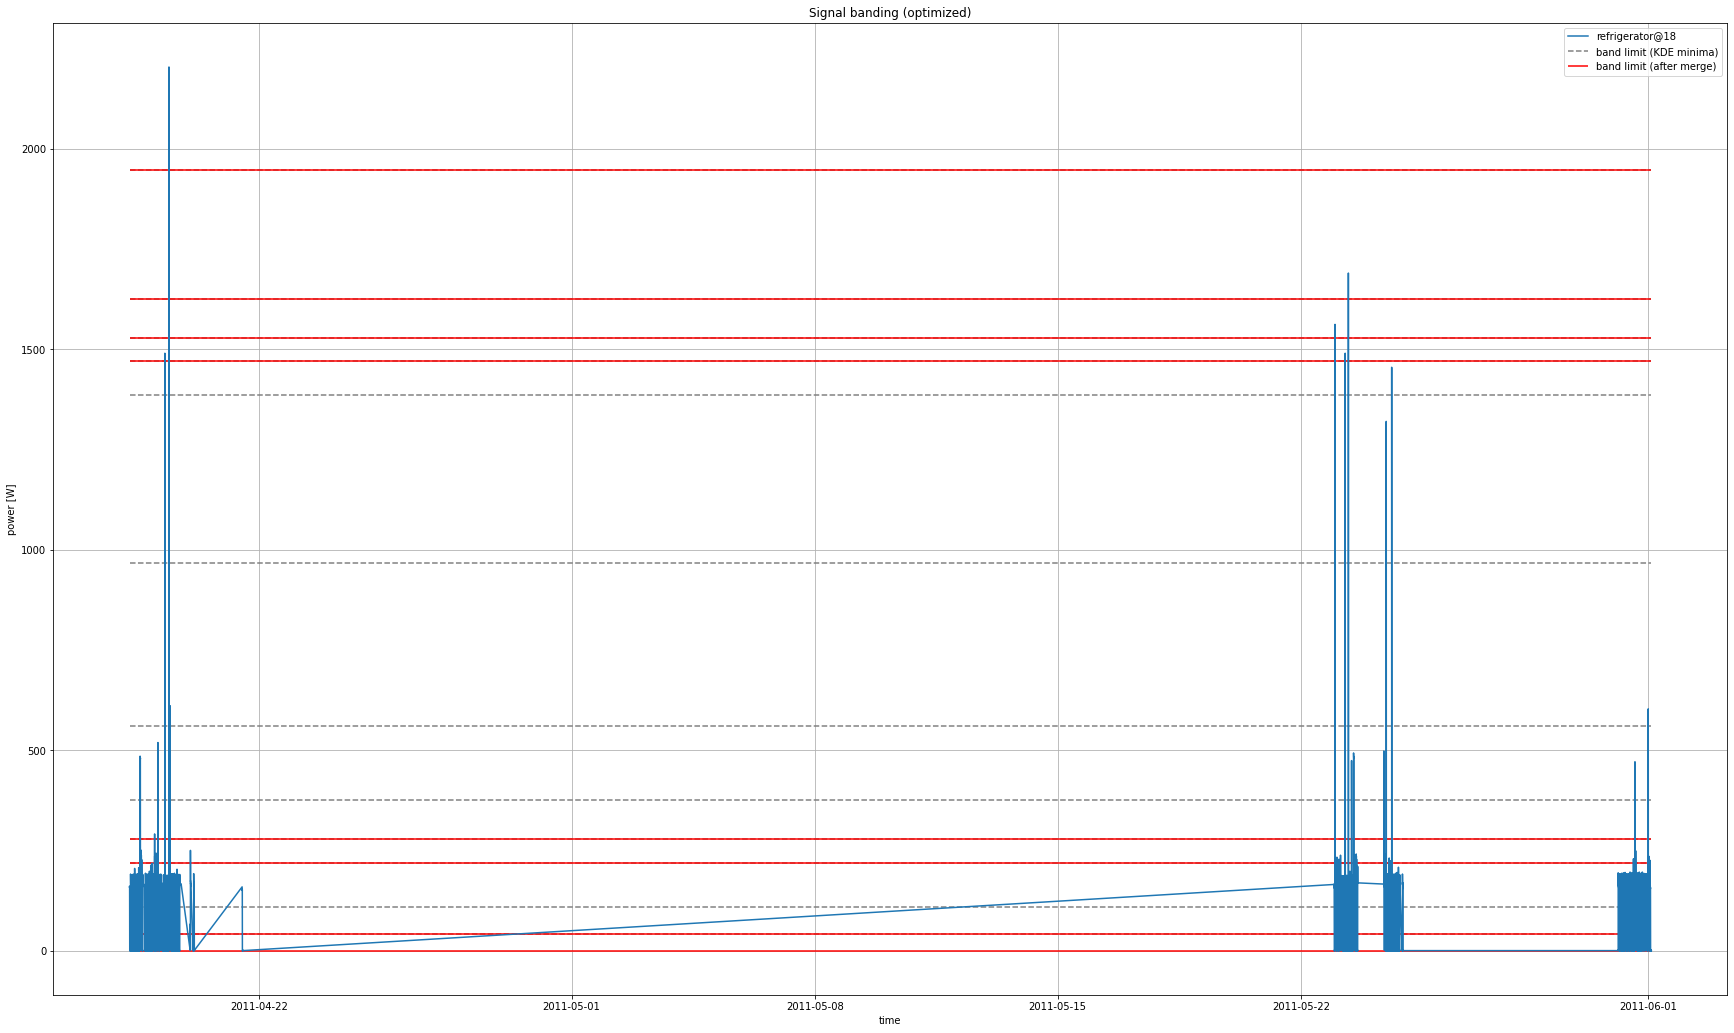

Power                                                  \
                        count         mean        std     min     25%     50%   
Band                                                                            
(-0.001, 40.794]      46312.0     0.285909   0.537173     0.0     0.0     0.0   
(40.794, 219.408]     30146.0   163.632555  12.141791    41.0   159.0   163.0   
(219.408, 278.945]      177.0   233.293785   7.239696   220.0   228.0   234.0   
(278.945, 1469.701]     811.0   483.821208  46.815227   291.0   479.0   483.0   
(1469.701, 1527.034]      2.0  1490.000000   0.000000  1490.0  1490.0  1490.0   
(1527.034, 1626.263]      1.0  1562.000000        NaN  1562.0  1562.0  1562.0   
(1626.263, 1947.106]      1.0  1690.000000        NaN  1690.0  1690.0  1690.0   
(1947.106, 2204.0]        1.0  2204.000000        NaN  2204.0  2204.0  2204.0   

                                      
                         75%     max  
Band                                  
(-0.001, 40.794]         1.0    26.0  
(40.794, 219.408]      168.0   219.0  
(219.408, 278.945]     236.0   256.0  
(278.945, 1469.701]    488.0  1455.0  
(1469.701, 1527.034]  1490.0  1490.0  
(1527.034, 1626.263]  1562.0  1562.0  
(1626.263, 1947.106]  1690.0  1690.0  
(1947.106, 2204.0]    2204.0  2204.0

In [21]:
opt_banded_channel = aggregate_bands(pd.DataFrame({'Power': channel}), 'Power', np.array(bands), joining_threshold = optimal_threshold)


fig = plt.figure()
fig.subplots_adjust(top=0.8)
axes = fig.add_subplot(1,1,1)
axes.set_title('Signal banding (optimized)')
axes.set_xlabel('time')
axes.set_ylabel('power [W]')
axes.plot(opt_banded_channel.index, opt_banded_channel['Power'], label=TARGET_CHANNEL_NAME)
axes.hlines(original_bands, opt_banded_channel.index.min(), opt_banded_channel.index.max(), linestyles='dashed', colors='gray', label='band limit (KDE minima)')
axes.hlines([x.left for x in opt_banded_channel['Band'].unique()], opt_banded_channel.index.min(), opt_banded_channel.index.max(), colors='r', label='band limit (after merge)')
axes.legend()
axes.grid(which='both')
plt.show()

opt_banded_channel.groupby('Band').describe()
